<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/LQ_control_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


## Exercise1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon import LQ

In [3]:
r = 0.05
beta = 1/(1+r)
c_bar = 1.5
mu, sigma = 2, 0.15
T, q = 50, 1e4
m0, m1, m2 = 0, T*mu/(T/2)**2, -mu/(T/2)**2
A = np.array([[1+r, -c_bar, m1, m2],
        [0, 1, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 2, 1]])
B = np.array([[-1],
        [0],
        [0],
        [0]])
C = np.array([[sigma],
        [0],
        [0],
        [0]])

Q = 1
R = np.zeros((4, 4))
R_f = np.zeros((4, 4))
R_f[0, 0] = q

In [4]:
lq1 = LQ(Q, R, A, B, C=C, N=None, beta=beta, T=T, Rf=R_f)

x_sims, u_sims, w_sims = lq1.compute_sequence((0, 1, 0, 0))

asset = x_sims[0, :]
consumption = u_sims.flatten() + c_bar
ts = np.arange(1, T+1)
income = m0 + m1*ts + m2*ts**2 + sigma*w_sims[0, 1:]

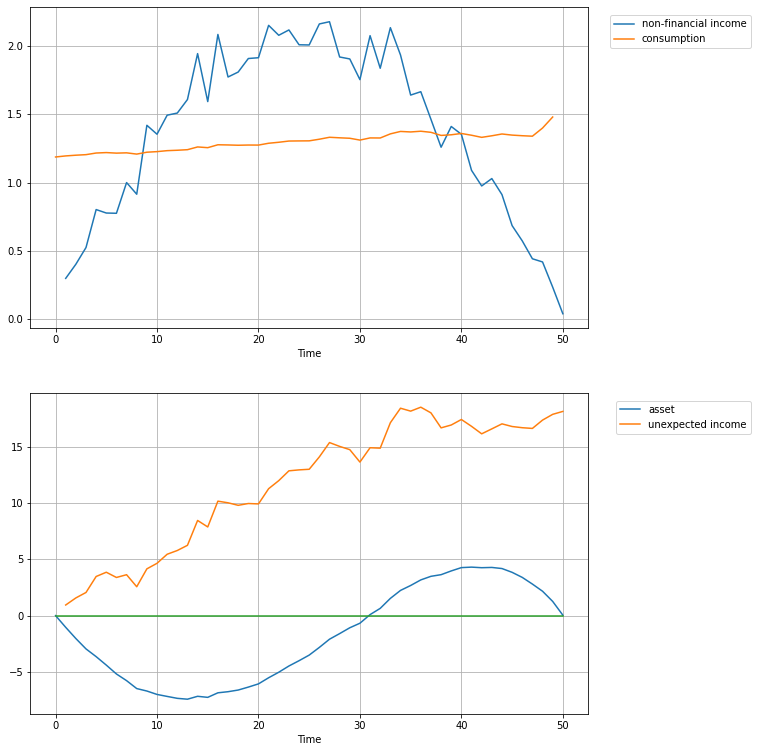

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 13))
ax1.plot(range(1, T+1), income, label="non-financial income")
ax1.plot(range(T), consumption, label='consumption')

ax2.plot(range(T+1), asset, label='asset')
ax2.plot(range(1, T+1), np.cumsum(w_sims[0, 1:]), label='unexpected income')
ax2.plot(range(T+1), np.zeros(T+1))

for ax in (ax1, ax2):
  ax.grid()
  ax.set(xlabel='Time')
  ax.legend(bbox_to_anchor=(1, 1, 0.3, -0.01))

## Exercise 2

In [8]:
r = 0.05
beta = 1/(1+r)
c_bar = 4
mu, sigma = 4, 0.35
K, T, q = 40, 60, 1e4
s = 1
m1, m2 = 2*K*mu/(K)**2, -mu/(K)**2
A_work = np.array([[1+r, -c_bar, m1, m2],
          [0, 1, 0, 0],
          [0, 1, 1, 0],
          [0, 1, 2, 1]])
B_work = np.array([[-1],
           [0],
           [0],
           [0]])
C_work = np.array([[sigma],
           [0],
           [0],
           [0]])

Q = 1
R_retired_and_work = np.zeros((4, 4))
R_f_retired = np.zeros((4, 4))
R_f_retired[0, 0] = q

A_retired = np.array([[1+r, -c_bar+s, 0, 0],
            [0, 1, 0, 0],
            [0, 1, 1, 0],
            [0, 1, 2, 1]])
B_retired = np.copy(B_work)
C_retired = np.zeros_like(C_work)

In [9]:
lq_retired = LQ(Q, R_retired_and_work, A_retired, B_retired, C=C_retired, beta=beta, T=T-K, Rf=R_f_retired)
for _ in range(T-K):
  lq_retired.update_values()

R_f_work = lq_retired.P

lq_work = LQ(Q, R_retired_and_work, A_work, B_work, C=C_work, beta=beta, T=K, Rf=R_f_work)

x_work, u_work, w_work = lq_work.compute_sequence((0, 1, 0, 0))

asset_work = x_work[0, :]
consumption_work = u_work.flatten() + c_bar
ts = np.arange(1, K+1)
income_work = m1*ts + m2*ts**2 + sigma*w_work[0, 1:]

x_retired, u_retired, w_retired = lq_retired.compute_sequence((asset_work[-1], 1, K, K))

asset_retired = x_retired[0, 1:]
consumption_retired = u_retired.flatten() + c_bar
income_retired = np.ones(T-K)

asset_life = np.concatenate((asset_work, asset_retired))
consumption_life = np.concatenate((consumption_work, consumption_retired))
income_life = np.concatenate((income_work, income_retired))

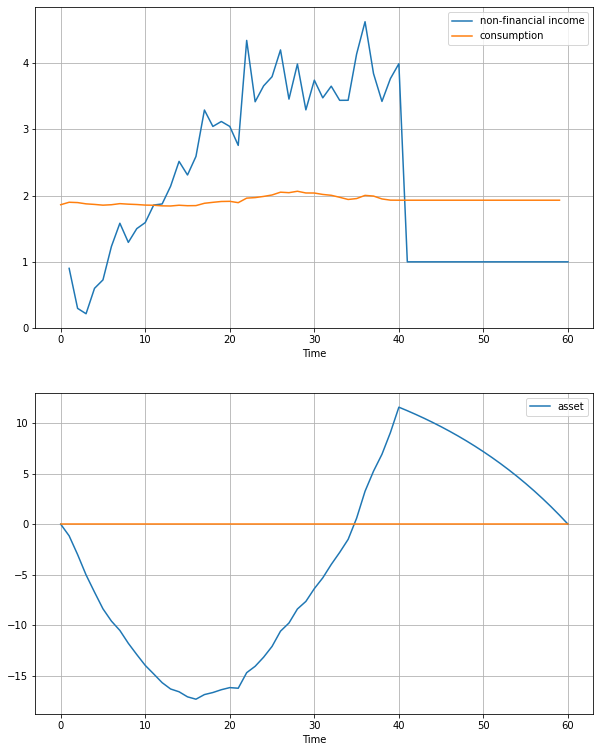

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 13))
ax1.plot(range(1, T+1), income_life, label="non-financial income")
ax1.plot(range(T), consumption_life, label='consumption')

ax2.plot(range(T+1), asset_life, label='asset')
ax2.plot(range(T+1), np.zeros(T+1))

for ax in (ax1, ax2):
  ax.grid()
  ax.set(xlabel='Time')
  ax.legend();

## Exercise 3

In [11]:
a0, a1 = 5, 0.5
beta = 0.95
sigma = 0.15
rho, c = 0.9, 2
gammas = [1, 10, 50]
A = np.array([[rho, 0, (1-rho)*(a0-c)/(2*a1)],
        [0, 1, 0],
        [0, 0, 1]])
B = np.array([[0],
        [1],
        [0]])
C = np.array([[sigma/(2*a1)],
        [0],
        [0]])

R = np.array([[a1, -a1, 0],
        [-a1, a1, 0],
        [0, 0, 0]])
T=150

In [12]:
def lq_model(Q, T=T):
  lq_profit = LQ(Q, R, A, B, C, beta=beta)
  x_sims, _, _ = lq_profit.compute_sequence(((a0-c)/(2*a1), 2, 1), ts_length=T)
  q_bar = x_sims[0, :]
  q = x_sims[1,:]
  return q_bar, q

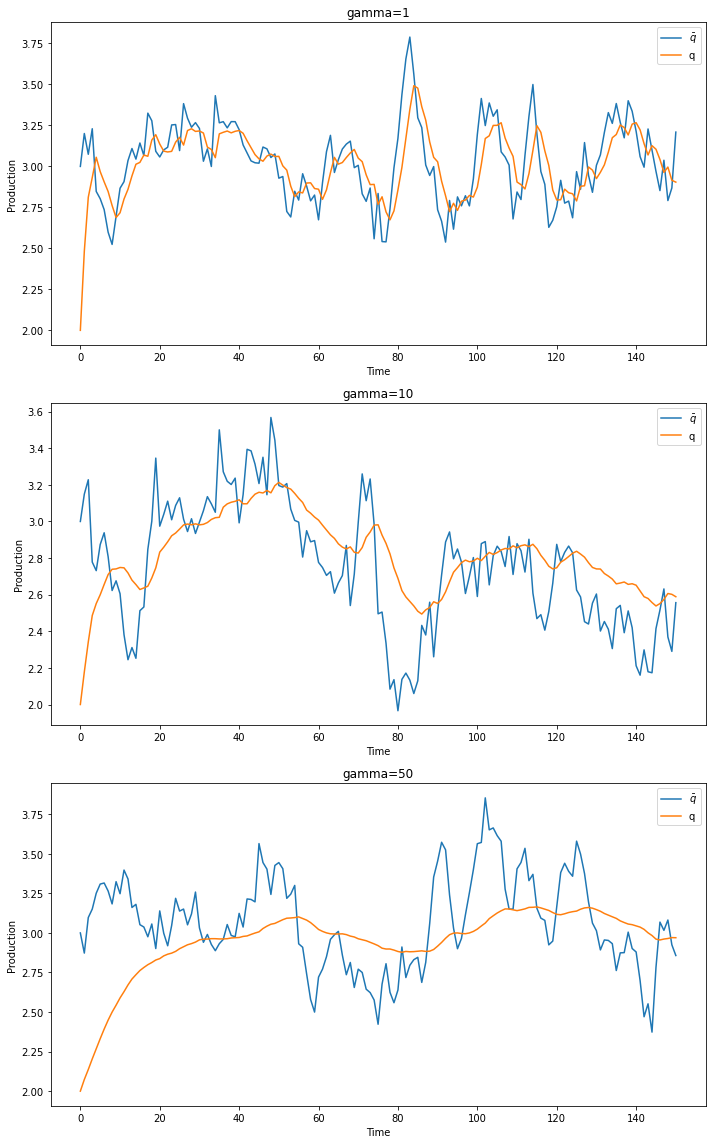

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(10, 16))
for ax, gamma in zip(axes, gammas):
  q_bar, q = lq_model(gamma)
  ax.plot(range(T+1), q_bar, label=r'$\bar{q}$')
  ax.plot(range(T+1), q, label='q')
  ax.legend()
  ax.set(xlabel='Time', ylabel='Production', title=f'gamma={gamma}')
fig.tight_layout();